## Neural Ratio Estimation

As usual we will start by importing the necessary libraries.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random


Next we generate a set of example gaussian absorption features. We sample our prior uniformly for the amplitude, width and central redshift of the signal. We generate 100,000 example signals for training and testing.

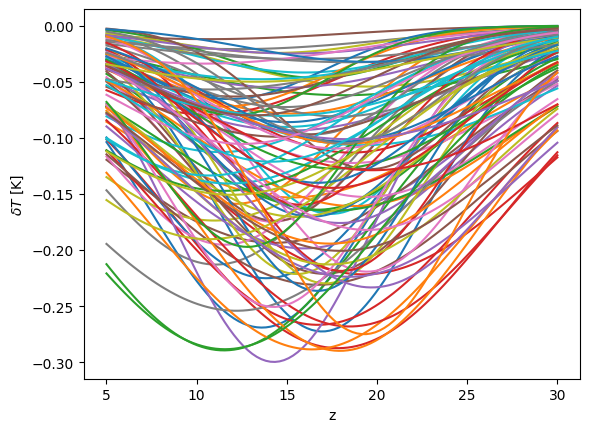

In [2]:
def gaussian(parameters):
    """a simple Gaussian function"""
    return -parameters[0] * \
        np.exp(-0.5*(z - parameters[1])**2/
               parameters[2]**2)

def prior(n):
    """a simple prior"""
    theta = np.ones((n, 3))
    theta[:, 0] = np.random.uniform(0.01, 0.3, n) # amplitude
    theta[:, 1] = np.random.uniform(10, 20, n) # mean
    theta[:, 2] = np.random.uniform(5, 10, n) # width
    return theta

z = np.linspace(5, 30, 100)[::-1]
n = 100000
theta = prior(n).astype(np.float32)
theta_min = np.array([0.01, 10, 5]).astype(np.float32)
theta_max = np.array([0.3, 20, 10]).astype(np.float32)
dims = theta.shape[1]
signals = np.array([gaussian(theta[i]) for i in range(n)])

[plt.plot(z, signals[i]) for i in range(100)]
plt.xlabel('z')
plt.ylabel(r'$\delta T$ [K]')
plt.savefig('example_signals.png', dpi=300, bbox_inches='tight')


Here we normalise the signals and perform a PCA compression on the training data.

In [3]:
norm_signals = (signals - signals.mean())/signals.std()
norm_params = (theta- theta.mean(axis=0))/theta.std(axis=0)

norm_data = np.hstack([norm_signals, norm_params])
norm_labels = np.ones(n)

idx = np.arange(0, len(norm_data))
random.shuffle(idx)
shuffled_params = norm_params[idx, :]
shuffled_data = np.hstack([norm_signals, shuffled_params])
shuffled_labels = np.zeros(n)

data = np.vstack([shuffled_data, norm_data])
labels = np.hstack([shuffled_labels, norm_labels])

idx = np.arange(0, 2*n)
random.shuffle(idx)
data = data[idx, :]
labels = labels[idx]


[11233 37424 57580 ... 71971 77392 80416]
(200000, 103) (200000,)


In [4]:
optimizer = tf.keras.optimizers.legacy.Adam(
                learning_rate=1e-3)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(norm_data.shape[1], activation='sigmoid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(100, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(100, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation='linear',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
])

In [5]:
@tf.function(jit_compile=True)
def _test_step(param, truth):
        
    r"""
    This function is used to calculate the loss value at each epoch and
    adjust the weights and biases of the neural networks via the
    optimizer algorithm.
    """
    prediction = tf.transpose(model(param, training=True))[0]
    prediction = tf.keras.layers.Activation('sigmoid')(prediction)
    truth = tf.convert_to_tensor(truth)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(truth, prediction)
    return loss

@tf.function(jit_compile=True)
def _train_step(params, truth):

    r"""
    This function is used to calculate the loss value at each epoch and
    adjust the weights and biases of the neural networks via the
    optimizer algorithm.
    """

    with tf.GradientTape() as tape:
        prediction = tf.transpose(model(params, training=True))[0]
        prediction = tf.keras.layers.Activation('sigmoid')(prediction)
        truth = tf.convert_to_tensor(truth)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(truth, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients,
            model.trainable_variables))
    return loss


2024-02-27 16:12:46.255384: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2e4105b40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-27 16:12:46.255404: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-27 16:12:46.268321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-27 16:12:46.564883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-27 16:12:46.566046: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Epoch: 0 Loss: 0.26646 Test Loss: 0.09221
Epoch: 1 Loss: 0.08659 Test Loss: 0.05270
Epoch: 2 Loss: 0.05891 Test Loss: 0.03474
Epoch: 3 Loss: 0.04916 Test Loss: 0.02895
Epoch: 4 Loss: 0.03888 Test Loss: 0.02523
Epoch: 5 Loss: 0.03347 Test Loss: 0.02681
Epoch: 6 Loss: 0.03077 Test Loss: 0.02572
Epoch: 7 Loss: 0.02651 Test Loss: 0.02490
Epoch: 8 Loss: 0.02567 Test Loss: 0.01336
Epoch: 9 Loss: 0.02593 Test Loss: 0.01664
Epoch: 10 Loss: 0.02179 Test Loss: 0.01143
Epoch: 11 Loss: 0.02189 Test Loss: 0.01211
Epoch: 12 Loss: 0.01971 Test Loss: 0.01090
Epoch: 13 Loss: 0.01807 Test Loss: 0.01141
Epoch: 14 Loss: 0.01677 Test Loss: 0.01134
Epoch: 15 Loss: 0.01377 Test Loss: 0.00822
Epoch: 16 Loss: 0.01523 Test Loss: 0.01243
Epoch: 17 Loss: 0.01571 Test Loss: 0.01328
Epoch: 18 Loss: 0.01568 Test Loss: 0.00913
Epoch: 19 Loss: 0.01398 Test Loss: 0.00872
Epoch: 20 Loss: 0.01539 Test Loss: 0.01224
Epoch: 21 Loss: 0.01110 Test Loss: 0.00813
Epoch: 22 Loss: 0.01219 Test Loss: 0.00973
Epoch: 23 Loss: 0.010

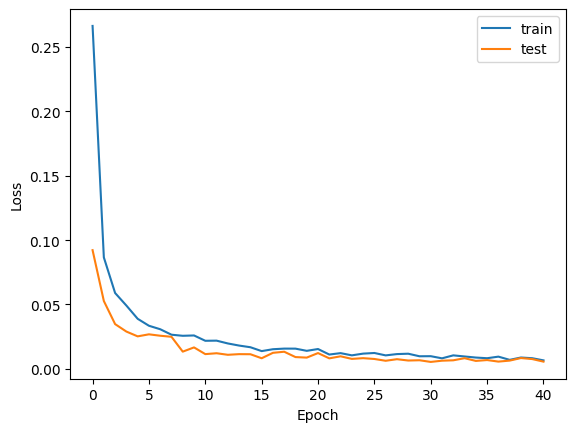

In [6]:

epochs = 50
batch_size = 300
patience = 10

data_train, data_test, labels_train, labels_test = \
        train_test_split(data, labels, test_size=0.2)

train_dataset = np.hstack([data_train, labels_train[:, np.newaxis]]).astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.batch(batch_size)

loss_history = []
test_loss_history = []
c = 0
#for i in tqdm.tqdm(range(epochs)):
for i in range(epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()

    loss = [_train_step(x[:, :-1], x[:, -1]) for x in  train_dataset]
    epoch_loss_avg.update_state(loss)
    loss_history.append(epoch_loss_avg.result())

    test_loss_history.append(_test_step(data_test, labels_test))
    print('Epoch: {} Loss: {:.5f} Test Loss: {:.5f}'.format(
        i, loss_history[-1], test_loss_history[-1]))

    c += 1
    if i == 0:
        minimum_loss = test_loss_history[-1]
        minimum_epoch = i
        minimum_model = model
    else:
        if test_loss_history[-1] < minimum_loss:
            minimum_loss = test_loss_history[-1]
            minimum_epoch = i
            minimum_model = model
            c = 0
    if minimum_model:
        if c == patience:
            print('Early stopped. Epochs used = ' + str(i) +
                    '. Minimum at epoch = ' + str(minimum_epoch))
            model = minimum_model
            break

plt.plot(loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_history.png', dpi=300, bbox_inches='tight')


In [38]:
def __call__(tdata, params):

        r_values = []
        for i in range(len(params)):
            ps = tf.convert_to_tensor(np.array([[*tdata, *params[i]]]).astype('float32'))
            logr = model(ps).numpy()[0]
            r_values.append(logr)

        r_values = np.array(r_values).T[0]
        return r_values

true_params = np.array([0.1, 15, 7])
true_data = gaussian(true_params)
true_signals = (true_data - signals.mean())/signals.std()



In [52]:

samples = prior(20000)
norm_params = (samples - theta.mean(axis=0))/theta.std(axis=0)

# logL - log Z
r_values = __call__(true_signals, norm_params)
prior_volume = np.log(np.prod(theta_max - theta_min))
logP = r_values + prior_volume
args = np.argsort(logP)
samples = samples[args]
logP = logP[args]

cbar = plt.scatter(samples[:, 0], samples[:, 1], c=logP- logP.max(), s=10, cmap='viridis')
plt.axvline(true_params[0], color='r', linestyle='--')
plt.axhline(true_params[1], color='r', linestyle='--')
plt.colorbar(cbar)
plt.xlabel(r'$A$')
plt.ylabel(r'$z_c$')
plt.savefig('example_posterior.png', dpi=300, bbox_inches='tight')

